# Identifying SARS-CoV-2 targets for a CIRTS-based viral inhibition strategy
## 1. Import human-virus PPI network
##### Network taken from: 
Gordon, D. E. et al. A SARS-CoV-2 protein interaction map reveals targets for drug repurposing. Nature https://doi.org/10.1038/s41586-020-2286-9 (2020).

In [1]:
# imported packages
import json
import pandas as pd
import numpy as np
import ndex2
import networkx as nx
import matplotlib
import os

In [3]:
# import from ndex
hpi_map = ndex2.create_nice_cx_from_server('public.ndexbio.org', 'arholman', 'pass', uuid=
'5d97a04a-6fab-11ea-bfdc-0ac135e8bacf')
hpi_map.print_summary()

Name: SARS-CoV-2 Host-Pathogen Interaction Map (Fig. 3))
Nodes: 359
Edges: 481
Node Attributes: 359
Edge Attributes: 3138



In [7]:
# make networkx object
hpi_map_networkx=hpi_map.to_networkx(mode='default')

# make it undirected
hpi_undirected = nx.Graph(hpi_map_networkx)

## 2. Import RNA targets with gene specificity

In [387]:
# potential RNA viral targets
cov_targ = os.path.join(os.environ["HOME"], "Dropbox/PhD UCSD/Coursework/Spring 2020/MED283/finalproj/", "sarscov2_conserved_unstructured.xlsx - sarscov2_conserved_unstructured.csv")
cov_raw = pd.read_csv(cov_targ, sep=",")
cov = cov_raw.iloc[0:78, 0:9]
cov

,Name,Region,Length,Gene,Nsp,Avg unpaired probability,Min unpaired probability,Human off-targets,Sequence
0,SARS-CoV-2-conserved-unstructured-1,27359-27407,49,Orf6/Orf7a,NaN,0.828686,0.645330,NaN,ATGAAGAGCAACCAATGGAGATTGATTAAACGAACATGAAAATTATTCT
1,SARS-CoV-2-conserved-unstructured-2,25408-25442,35,Orf3a,NaN,0.797974,0.641586,NaN,AGAATCTTCACAATTGGAACTGTAACTTTGAAGCA
2,SARS-CoV-2-conserved-unstructured-3,15137-15175,39,Orf1ab,Nsp12,0.800312,0.622881,NaN,TGACCAATAGACAGTTTCATCAAAAATTATTGAAATCAA
3,SARS-CoV-2-conserved-unstructured-4,9497-9544,48,Orf1ab,Nsp4,0.785620,0.603424,NaN,GTTGCCTTTAATACTTTACTATTCCTTATGTCATTCACTGTACTCTGT
4,SARS-CoV-2-conserved-unstructured-5,29348-29394,47,N,NaN,0.922912,0.602905,NaN,GCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAA
...,...,...,...,...,...,...,...,...,...
73,SARS-CoV-2-conserved-unstructured-74,4551-4597,47,Orf1ab,Nsp3,0.766988,0.500261,NaN,CAACTGTAGCGTCACTTATCAACACACTTAACGATCTAAATGAAACT
74,SARS-CoV-2-conserved-unstructured-75,7419-7453,35,Orf1ab,Nsp3,0.714621,0.500227,NaN,TCTTCTTTGCATCATTTTATTATGTATGGAAAAGT
75,SARS-CoV-2-conserved-unstructured-76,7337-7409,73,Orf1ab,Nsp3,0.740859,0.500083,NaN,TTTATTAGTAATTCTTGGCTTATGTGGTTAATAATTAATCTTGTAC...
76,SARS-CoV-2-conserved-unstructured-77,23654-23721,68,Spike,NaN,0.815099,0.500077,NaN,TCACTTGGTGCAGAAAATTCAGTTGCTTACTCTAATAACTCTATTG...


## 3. Add in BioPlex data

In [4]:
bioplex = ndex2.create_nice_cx_from_server('public.ndexbio.org', uuid=
'98ba6a19-586e-11e7-8f50-0ac135e8bacf')
bioplex.print_summary()

Name: BioPlex 2.0 ( ~ 56,000 interactions )
Nodes: 10961
Edges: 56553
Node Attributes: 10961
Edge Attributes: 169659



In [5]:
# make networkx object from BioPlex network
bioplex_networkx_directed=bioplex.to_networkx(mode='default')

# make undirected
bioplex_nx = nx.MultiGraph(bioplex_networkx_directed)

## 4. Merge human-CoV dataset with all of BioPlex

In [1]:
# merge bioplex with hpi
hpi_bioplex = nx.compose(bioplex_nx, hpi_map_networkx)

In [9]:
# make it undirected
hpi_undirected = nx.Graph(hpi_bioplex)

## 5. Calculate Centrality for all proteins in human-CoV dataset and BioPlex network

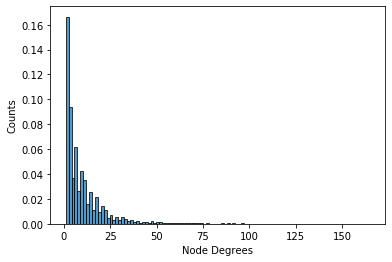

In [11]:
import matplotlib.pyplot as plt
deg = hpi_undirected.degree

# pull all the node degrees
degree = []
for (x,y) in list(deg):
    degree.append(y)

# pull all unique node degrees for number of bins
uniq_degree = []
for u in degree:
    if u not in uniq_degree: 
        uniq_degree.append(u)

# plot node degrees vs. counts
plt.hist(degree, alpha=0.75, density=True, bins=(len(uniq_degree)), stacked=True, edgecolor='black')
plt.xlabel('Node Degrees')
plt.ylabel('Counts')
plt.show()

In [12]:
# determine centrality of proteins of interest
ec = nx.eigenvector_centrality(hpi_undirected)
bc = nx.betweenness_centrality(hpi_undirected)
dc = nx.degree_centrality(hpi_undirected)

# isolate eigenvector centrality
ec_prob = []
for key, value in ec.items():
    ec_prob.append(value)

# isolate betweenness centrality
bc_prob = []
for key, value in bc.items():
    bc_prob.append(value)

# isolate degree centrality
dc_prob = []
for key, value in dc.items():
    dc_prob.append(value) 

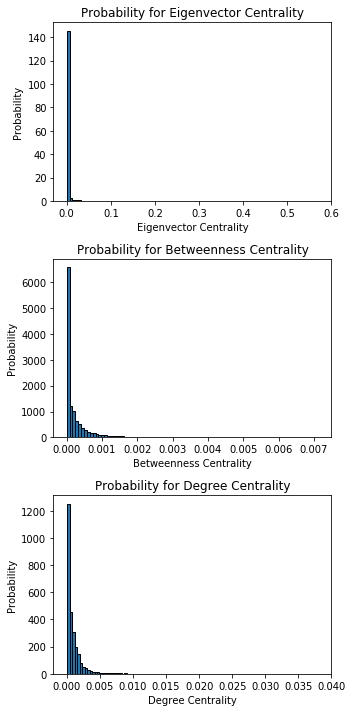

In [13]:
# plot centrality measures
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,1, figsize=(5, 10), tight_layout=True)
axs[0].hist(ec_prob, bins=30, density=True, edgecolor='black')
axs[0].set_xlabel('Eigenvector Centrality')
axs[0].set_ylabel('Probability')
axs[0].set_title('Probability for Eigenvector Centrality')
a1 = 0.6
axs[0].set_xlim(left=-(a1/20), right=a1)

axs[1].hist(bc_prob, bins=300, density=True, edgecolor='black')
axs[1].set_xlabel('Betweenness Centrality')
axs[1].set_ylabel('Probability')
axs[1].set_title('Probability for Betweenness Centrality')
a2 = 0.0075
axs[1].set_xlim(left=-(a2/20), right=a2)

axs[2].hist(dc_prob, bins=40, density=True, edgecolor='black')
axs[2].set_xlabel('Degree Centrality')
axs[2].set_ylabel('Probability')
axs[2].set_title('Probability for Degree Centrality')
a3 = 0.04
axs[2].set_xlim(left=-(a3/20), right=a3)

plt.show()

In [14]:
## find top hit by looking at degree and centrality
# highest degree value
for key, value in deg:
    if value == max(degree): 
        max_degree = key

node_atr = nx.get_node_attributes(hpi_bioplex, 'name')
for key, value in node_atr.items():
    if key == max_degree:
        degree_gene = value

# highest ec value
for key, value in ec.items():
    if value == max(ec_prob): 
        max_ec = key
        
for key, value in node_atr.items():
    if key == max_ec:
        ec_gene = value

# highest bc value
for key, value in bc.items():
    if value == max(bc_prob): 
        max_bc = key
        
for key, value in node_atr.items():
    if key == max_bc:
        bc_gene = value
        
# highest dc value
for key, value in dc.items():
    if value == max(dc_prob): 
        max_dc = key
        
for key, value in node_atr.items():
    if key == max_dc:
        dc_gene = value

print("{} has the highest eigenvector centrality of {}.".format((ec_gene), (max(ec_prob))))
print("{} has the highest betweenness centrality of {}.".format((bc_gene), (max(bc_prob))))
print("{} has the highest degree centrality of {}.".format((dc_gene), (max(dc_prob))))
print("{} has the highest degree of {}.".format((degree_gene), (max(degree))))

RBM34 has the highest eigenvector centrality of 0.19740163355407062.
HSPA8 has the highest betweenness centrality of 0.024560562095865726.
HSPA8 has the highest degree centrality of 0.015054744525547444.
HSPA8 has the highest degree of 165.


In [23]:
# first, sort centrality lists by value
sort_ec = sorted(ec.items(), key=lambda x: x[1], reverse=True)
sort_bc = sorted(bc.items(), key=lambda x: x[1], reverse=True)
sort_dc = sorted(dc.items(), key=lambda x: x[1], reverse=True)

# generate scores for each centrality measure where 0 is a top score
score_ec = []
for i in range(len(sort_ec)):
    new = list(sort_ec[i])
    new.append(i)
    score_ec.append(new)
    
score_bc = []
for i in range(len(sort_bc)):
    new = list(sort_bc[i])
    new.append(i)
    score_bc.append(new)
    
score_dc = []
for i in range(len(sort_dc)):
    new = list(sort_dc[i])
    new.append(i)
    score_dc.append(new)

# now, sort by node index
sort_ec = sorted(score_ec, key=lambda x: x[0], reverse=True)
sort_bc = sorted(score_bc, key=lambda x: x[0], reverse=True)
sort_dc = sorted(score_dc, key=lambda x: x[0], reverse=True)

# merge all centrality scores by node index
final = []
for i in range(len(sort_ec)):
    new = list(sort_ec[i])
    new.append(sort_bc[i][2])
    final.append(new)
    
lists = []    
for i in range(len(sort_ec)):
    new = final[i]
    new.append(sort_dc[i][2])
    lists.append(new)  

# sum scores to get overall rankins
scores = []
for i in range(len(lists)):
    new = list(lists[i])
    new.append(sum(lists[i][2:5]))
    scores.append(new)

    
# sort by these final scores and generate list with rankings
sorted_scores = sorted(scores, key=lambda x: x[5])

final_score = []
for i in range(len(sorted_scores)):
    new = list(sorted_scores[i])
    new.append(node_atr[sorted_scores[i][0]])
    final_score.append(new)

final_scores = []
for i in range(len(final_score)):
    new = list([final_score[i][6], final_score[i][5], final_score[i][0]])
    new.append(i)
    final_scores.append(new)
    
print(len(final_scores))

10961


In [19]:
# COVID proteins
cov_list = os.path.join(os.environ["HOME"], "Dropbox/PhD UCSD/Coursework/Spring 2020/MED283/finalproj/", "protein_list.csv")
cov_prot = pd.read_csv(cov_list, sep=",", header=None)
cov_prot.columns = ['na','full', 'short', 'alt', 'notes']
modified = cov_prot.iloc[2:32, 0:5]

In [102]:
## only select genes that are in our RNA target list
# first, finding unique genes that RNA targets
unique_genes = ['Orf9c', 'Nsp11', 'S', 'Orf3b']
for g in modified.loc[:,"short"]:
    if g not in unique_genes: unique_genes.append(g)

for g in modified.loc[:,"alt"]:
    if g not in unique_genes: unique_genes.append(g)

# next, see order among genes on RNA targets
RNA_target_ranking = []
for i in range(len(final_scores)):
    if final_scores[i][0] in unique_genes:
        new = list([final_scores[i][0], final_scores[i][2], final_scores[i][3], final_scores[i][1]])
        RNA_target_ranking.append(new)

RNA_target_ranking
# print(unique_genes)

[['Nsp12', 2562, 24, 491],
 ['Orf8', 2363, 236, 1674],
 ['E', 2634, 276, 1839],
 ['Nsp7', 2465, 278, 1842],
 ['Orf9c', 2303, 537, 2874],
 ['Nsp8', 2433, 628, 3231],
 ['Orf9b', 2315, 653, 3304],
 ['M', 2627, 700, 3435],
 ['Nsp13', 2541, 714, 3471],
 ['Nsp4', 2484, 827, 3815],
 ['Nsp11', 2564, 875, 3934],
 ['Orf3a', 2381, 1201, 4885],
 ['Nsp9', 2408, 1313, 5206],
 ['Orf6', 2370, 1800, 6570],
 ['N', 2596, 1918, 6875],
 ['Nsp5', 2475, 1994, 7041],
 ['Orf3b', 2372, 2229, 7632],
 ['Nsp1', 2577, 2441, 8162],
 ['Orf10', 2391, 2517, 8347],
 ['Nsp2', 2492, 3426, 10789],
 ['Nsp15', 2496, 3646, 11385],
 ['Nsp14', 2500, 3688, 11506],
 ['Spike', 2580, 3858, 11950],
 ['Orf7a', 2366, 4461, 13520],
 ['Nsp6', 2470, 5298, 15704],
 ['Nsp10', 2570, 5521, 16317]]

### 5.1 Generate table with centrality values and scores
Exported this data into other jupyter notebook for final calculation

In [105]:
# make a table with 1st degree neighbors
sort_ec = sorted(score_ec, key=lambda x: x[0], reverse=True)
sort_bc = sorted(score_bc, key=lambda x: x[0], reverse=True)
sort_dc = sorted(score_dc, key=lambda x: x[0], reverse=True)
sort_final = sorted(final_scores, key=lambda x: x[2], reverse=True)

table = []
for i in range(len(sort_ec)):
    x = (sort_final[i][0], sort_final[i][2], sort_final[i][3], sort_ec[i][1], sort_bc[i][1], sort_dc[i][1], sort_final[i][1])
    table.append(x)

    
table_sorted = sorted(table, key=lambda x: x[2])

# next, see order among genes on RNA targets
covid_table = []
a = 0
for i in range(len(table_sorted)):
    if table_sorted[i][0] in unique_genes:
        a += 1
        new = list([table_sorted[i][0], table_sorted[i][1], a, table_sorted[i][3], table_sorted[i][4], table_sorted[i][5], table_sorted[i][6]])
        covid_table.append(new)

# table
dfcovid_table = pd.DataFrame(covid_table)
dfcovid_table.columns = ['Protein','Index', 'Ranking', 'Eigenvector Centrality', 'Betweenness Centrality', 'Degree Centrality', 'Score']
dfcovid_table

# dfcovid_table.to_csv('df.csv')

,Protein,Index,Ranking,Eigenvector Centrality,Betweenness Centrality,Degree Centrality,Score
0,Nsp12,2562,1,0.026470,0.002416,0.006022,491
1,Orf8,2363,2,0.001000,0.004981,0.005474,1674
2,E,2634,3,0.002135,0.002260,0.002920,1839
3,Nsp7,2465,4,0.002356,0.001672,0.003193,1842
4,Orf9c,2303,5,0.000538,0.002446,0.003650,2874
5,Nsp8,2433,6,0.001540,0.000699,0.002372,3231
6,Orf9b,2315,7,0.000480,0.001581,0.003558,3304
7,M,2627,8,0.000493,0.001552,0.003011,3435
8,Nsp13,2541,9,0.000498,0.000970,0.004380,3471
9,Nsp4,2484,10,0.000596,0.000934,0.002464,3815


## 6. Find cliques for all of BioPlex + human-CoV dataset

In [2]:
# make merged network
hpi_bioplex = nx.compose(bioplex_networkx_directed, hpi_map_networkx)

In [98]:
# make undirected
hpi_undirected = nx.Graph(hpi_bioplex)

In [99]:
# COVID index vals
all_index = list(dfcovid_table.loc[:,'Index'])

In [101]:
# cliques in KCNH2
all_cliques = []
for i in all_index:
    a = nx.cliques_containing_node(hpi_undirected, nodes=[i])
    for c in list(a.values()):
        for i in c:
            all_cliques.append(i)

all_cliques
[len(c) for c in sorted(all_cliques, key=len, reverse=True)]
# a = nx.cliques_containing_node(hpi_undirected, nodes=[all_index[2]])
# b = list(a.values())
# b[0]

[14,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,

Outcome: same cliques as human-CoV + 1st degree neighbors, so decided to use the network with less nodes

## 7. Connected component analysis for all of BioPlex + human-CoV dataset

In [107]:
hpi_bioplex_und = nx.MultiGraph(hpi_bioplex)
connected = nx.connected_components(hpi_bioplex_und)

connect = []
for c in connected:
    if len(c) > 1:
        connect.append(c)
print([len(c) for c in sorted(nx.connected_components(hpi_bioplex_und), key=len, reverse=True)])
sorted_con = sorted(nx.connected_components(hpi_bioplex_und), key=len, reverse=True)

# used http://biit.cs.ut.ee/gprofiler/gost
# for GO terms, used BP and pulled 1st term

# connect_0 = []
# node_atr = nx.get_node_attributes(hpi_bioplex_und, 'name')
# for key, value in node_atr.items():
#     for i in sorted_con[54]:
#         if key == i:
#             print(value)
#             connect_0.append(value)        

[10901, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [108]:
stconnected = nx.strongly_connected_components(hpi_bioplex)
[len(c) for c in sorted(stconnected, key=len, reverse=True)]


[1628,
 5,
 3,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 

In [92]:
# find which clusters COVID-associated genes are in
clusters = []
name = dfcovid_table.loc[:,'Protein']
index = dfcovid_table.loc[:,'Index']
for v in range(len(index)):
    for i in range(len(sorted_con)):
        if index[v] in sorted_con[i]:
            start = (name[v], i)
            clusters.append(start)
            
sorted(clusters, key=lambda x: x[1])

[('Nsp12', 0),
 ('Orf8', 0),
 ('E', 0),
 ('Nsp7', 0),
 ('Nsp8', 0),
 ('Orf9b', 0),
 ('M', 0),
 ('Nsp13', 0),
 ('Nsp4', 0),
 ('Orf3a', 0),
 ('Nsp9', 0),
 ('Orf6', 0),
 ('N', 0),
 ('Nsp5', 0),
 ('Nsp1', 0),
 ('Orf10', 0),
 ('Nsp2', 0),
 ('Nsp15', 0),
 ('Nsp14', 0),
 ('Spike', 0),
 ('Orf7a', 0),
 ('Nsp6', 0),
 ('Nsp10', 0)]

Outcome: clearly there are either a small number of proteins in each component or the whole dataset is the component. 